In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate
import tensorflow_addons as tfa
from keras.layers import Flatten, Dense, Dropout
import tifffile

from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer, normalize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import os

import scipy
from numba import cuda 

2023-03-21 07:08:23.120454: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 07:08:24.013633: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/amazon/efa/lib:/opt/amazon/openmpi/lib:/usr/local/cuda/efa/lib:/usr/local/cuda/lib:/usr/local/cuda:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/targets/x86_64-linux/lib:/usr/local/lib:/usr/lib:/opt/amazon/efa/lib:/opt/amazon/openmpi/lib:/usr/local/cuda/efa/lib:/usr/local/cuda/lib:/usr/local/cuda:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cud

In [2]:
# !pip install numpy tensorflow matplotlib scipy
# # !pip install pandas
# !pip install tifffile
# !pip install scikit-learn
# !pip install imagecodecs
# !pip install tensorflow-addons
# !pip install numba
# !pip install ipyplot

In [3]:
def reset_gpu():
    device = cuda.get_current_device()
    device.reset()

In [4]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
   # plt.plot(history.history['accuracy'], label='accuracy')
   # plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 
            max(
                max(history.history['loss']),
                max(history.history['val_loss'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

In [61]:
# tiles = pd.read_csv(r'Data/Tiles_expanded.csv')
tiles_expanded_rv = pd.read_csv(r'Data/Tiles_TRAIN.csv')#.drop(['Unnamed: 0'],axis=1)
# tiles_expanded_rv = pd.get_dummies(tiles_expanded_rv, columns = ['RTTYP'])

In [29]:
tiles_expanded_rv.head()

,Tile_ID,Stop_Signs,Paving_historical,Bus_stop,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U,...,94129,94130,94131,94132,94133,94134,94141,94143,94158,94188
0,10993,0.0,0.0,0.0,2.0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,13338,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10163,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7523,1.0,0.0,1.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10314,2.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# tiles_expanded_rv['Collisions_Future_binary']=tiles_expanded_rv['Collisions_Future'].apply(lambda x: 1 if x > 0 else 0)
# tiles_expanded_rv['Collisions_Historical_binary']=tiles_expanded_rv['Collisions_Historical'].apply(lambda x: 1 if x > 0 else 0)

In [31]:
tiles_expanded_rv['bins_numeric'], bin_keys = pd.factorize(tiles_expanded_rv['bins_numeric'])
# tiles_expanded_rv.columns

In [54]:
bin_keys
# tiles_expanded_rv.columns

Int64Index([3, 2, 0, 5, 4, 6, 1, 7, 10, 8, 9], dtype='int64')

In [53]:
tiles_expanded_rv['bins_numeric'].value_counts()

2     6644
1     1201
0      283
6      134
5       61
4       26
7       14
3        5
9        4
8        3
10       1
Name: bins_numeric, dtype: int64

# Normalize data

In [35]:
# def normalize_col(df, col_name):

#     norm = (df[col_name] - df[col_name].min()) / (df[col_name].max() - df[col_name].min())
#     return norm

# tiles_expanded_rv['Mid_lat_norm'] = normalize_col(tiles_expanded_rv,'Mid_lat')
# tiles_expanded_rv['Mid_long_norm'] = normalize_col(tiles_expanded_rv,'Mid_long')


Split into training and test

In [36]:
MODEL_TYPE='logistic' # 'linear'

if MODEL_TYPE == 'linear':
    input_x = ['Tile_ID','Collisions_Historical', 'Mid_lat_norm','Mid_long_norm', 'Stop_Signs', 'Paving_historical', 'Bus_stop','RTTYP_I','RTTYP_M','RTTYP_S','RTTYP_U'] # Removing RTTYP_O
    input_y = ['Collisions_Future']
elif MODEL_TYPE == 'logistic':
    input_x = ['Tile_ID', 'Stop_Signs', 'Paving_historical', 'Bus_stop',
       'Collisions_Historical', 'RTTYP_I', 'RTTYP_M', 'RTTYP_O', 'RTTYP_S',
       'RTTYP_U', '94101', '94102', '94104', '94105', '94107',
       '94108', '94109', '94110', '94111', '94112', '94114', '94115', '94116',
       '94117', '94118', '94121', '94122', '94123', '94124', '94127', '94129',
       '94130', '94131', '94132', '94133', '94134', '94141', '94143', '94158',
       '94188']
    input_y = ['bins_numeric']
    

x_train, x_test, y_train, y_test = train_test_split(
                                    tiles_expanded_rv[input_x], 
                                    tiles_expanded_rv[input_y],
                                    random_state=104, 
                                    test_size=0.20, 
                                    shuffle=True)



Model #1: Linear regression using Historical Collisions, SFMTA Street Characteristics, and Geocoordinates

## Image Pre-Processing

In [37]:
IMAGE_PATH = 'Satellite_Imagery/Satellite_Images_Tiled/' 

In [38]:
 #eda
img = tifffile.imread('Satellite_Imagery/Satellite_Images_Tiled/36.tif')[0:148, 0:188, :]
img2 = tifffile.imread('Satellite_Imagery/Satellite_Images_Tiled/37.tif')[0:148, 0:188, :]

In [39]:
# eda
print(np.shape(img2))

(148, 188, 4)


In [40]:
# eda
test = []
test.append(img[0:148, 0:188, :])
test.append(img2[0:148, 0:188, :])
print(np.shape(test))
test = np.stack(test)
print(np.shape(test))

(2, 148, 188, 4)
(2, 148, 188, 4)


In [41]:
def preprocess_data_part1(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    data_mini_test = []
    for id in x_train['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    for id in x_test['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]
            
        # append to images
        data_mini_test.append(image)
 
    # stack images and trasnform to array
    images_mini_test = np.stack(data_mini_test)
    
    return images_mini, images_mini_test

In [42]:
# THERE IS ONE FILE IN THE "SATELLITE IMAGES TILED" FOLDER THAT IS NOT A TIF IMAGE, DELETE THIS FILE
images_mini, images_mini_test = preprocess_data_part1(IMAGE_PATH)

In [43]:
np.shape(images_mini)
np.shape(images_mini_test)

(1676, 148, 188, 4)

In [44]:
# images_mini_reshaped = images_mini.reshape((8376,1,1,111296))

In [45]:
# images_mini_reshaped.shape
# len(images_mini_reshaped[0][0][0])

Street Data Pre-Processing

In [46]:
x_train

,Tile_ID,Stop_Signs,Paving_historical,Bus_stop,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U,...,94129,94130,94131,94132,94133,94134,94141,94143,94158,94188
1762,1526,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4603,11426,0.0,7.0,0.0,8.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6484,13993,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6950,3201,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4254,13779,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5247,4660,0.0,1.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6310,7485,4.0,1.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
729,8882,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5825,3436,2.0,5.0,2.0,0.0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [47]:
street = np.asarray(x_train[input_x[1:]]).astype('float32')
street_mini = []
for row in street:
    street_mini.append([[row]])
street_mini = np.stack(street_mini)
np.shape(street_mini)


street_test = np.asarray(x_test[input_x[1:]]).astype('float32')
street_mini_test = []
for row in street_test:
    street_mini_test.append([[row]])
street_mini_test = np.stack(street_mini_test)
np.shape(street_mini_test)

(1676, 1, 1, 39)

In [48]:
print(street_mini.shape)
print(images_mini.shape)

(6700, 1, 1, 39)
(6700, 148, 188, 4)


In [49]:
input_image_street = np.hstack(
    (street_mini.reshape((6700,39)),
    normalize(images_mini.reshape(6700,-1))
     # images_mini.reshape(8376,148*188*4)
    )
)

In [50]:
print(street_mini_test.shape)
print(images_mini_test.shape)

(1676, 1, 1, 39)
(1676, 148, 188, 4)


In [51]:
input_image_street_test = np.hstack(
    (street_mini_test.reshape((1676,39)),
    # images_mini_test.reshape((2095,148*188*4))
    normalize(images_mini_test.reshape(1676,-1))
    ))

In [52]:
input_image_street_test.shape

(1676, 111335)

## Linear Regression

In [ ]:
# x: 'Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop','RTTYP_I','RTTYP_M','RTTYP_O','RTTYP_S','RTTYP_U'
# y: 'Collisions_Future'

def create_linear_model():
    # DENSE LAYERS 
    input = tf.keras.layers.Input(shape=(111306,))

    outputs = layers.Dense(1)(input)

    linear_model = tf.keras.models.Model(inputs=input, outputs=outputs, name="linear_model")

    linear_model.summary()

    linear_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error'
        )
    
    return linear_model

linear_model = create_linear_model()

# history = linear_model.fit(
#     input_image_street,
#      np.stack(y_train['Collisions_Future'].to_numpy()),
#     epochs=100,
#     # Suppress logging.
#      verbose=1,
#     # Calculate validation results on 20% of the training data.
#     validation_split = 0.2)


In [ ]:
# plot_loss(history)

In [ ]:
# predict_result = history.model.predict(input_image_street_test)

In [ ]:
# predict_result.shape

## Mean squared error

In [ ]:
# np.square(predict_result - y_test['Collisions_Future'].to_numpy().reshape((649,1))).mean()

## LOGISTIC MODEL WITH IMAGES

Model: "logistic_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 111335)]          0         
                                                                 
 dense (Dense)               (None, 11)                1224696   
                                                                 
Total params: 1,224,696
Trainable params: 1,224,696
Non-trainable params: 0
_________________________________________________________________


2023-03-21 07:15:22.321421: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 07:15:22.328237: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 07:15:22.328571: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 07:15:22.329250: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Epoch 1/50


2023-03-21 07:15:28.154167: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f486c01dba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-21 07:15:28.154213: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla M60, Compute Capability 5.2
2023-03-21 07:15:28.160818: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-21 07:15:28.329845: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


168/168 [==============================] - 3s 15ms/step - loss: 0.7245 - accuracy: 0.7841 - val_loss: 0.6369 - val_accuracy: 0.7985
Epoch 2/50
168/168 [==============================] - 1s 8ms/step - loss: 0.6263 - accuracy: 0.7924 - val_loss: 0.6100 - val_accuracy: 0.8000
Epoch 3/50
168/168 [==============================] - 1s 8ms/step - loss: 0.5892 - accuracy: 0.7966 - val_loss: 0.5717 - val_accuracy: 0.8052
Epoch 4/50
168/168 [==============================] - 1s 8ms/step - loss: 0.5600 - accuracy: 0.8000 - val_loss: 0.5619 - val_accuracy: 0.8067
Epoch 5/50
168/168 [==============================] - 1s 8ms/step - loss: 0.5409 - accuracy: 0.8049 - val_loss: 0.5446 - val_accuracy: 0.8097
Epoch 6/50
168/168 [==============================] - 1s 8ms/step - loss: 0.5283 - accuracy: 0.8067 - val_loss: 0.5395 - val_accuracy: 0.8104
Epoch 7/50
168/168 [==============================] - 1s 8ms/step - loss: 0.5131 - accuracy: 0.8129 - val_loss: 0.5428 - val_accuracy: 0.8127
Epoch 8/50
168/1

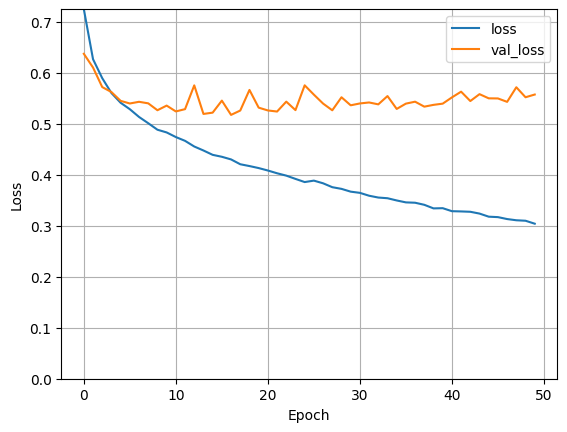

In [55]:
# x: 'Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop','RTTYP_I','RTTYP_M','RTTYP_O','RTTYP_S','RTTYP_U'
# y: 'Collisions_Future'

def create_logistic_model():
    # DENSE LAYERS 
    input = tf.keras.layers.Input(shape=(111335,))
    
    # input = keras.layers.Flatten()(input)

    outputs = keras.layers.Dense(units = 11, activation = 'softmax')(input)

    log_model = tf.keras.models.Model(inputs=input, outputs=outputs, name="logistic_model")

    log_model.summary()

    log_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
        )
    
    return log_model

logistic_model = create_logistic_model()

class_weight = {0: 1,
                1: 100000,
                2: 100000,
                3: 100000,
                4: 100000,
                5: 100000,
                6: 100000,
                7: 100000,
                8: 100000,
                9: 100000,
                10: 100000,
               }

history = logistic_model.fit(
    input_image_street,
    np.stack(y_train.to_numpy()),
     # y_train_2,
    epochs=50,
    # Suppress logging.
     # verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2,
#     class_weight = class_weight
    )

plot_loss(history)

In [56]:
predict_result = history.model.predict(input_image_street_test)

53/53 [==============================] - 0s 5ms/step


In [57]:
predict_result[55]

array([4.9633002e-03, 2.3260666e-01, 7.6227856e-01, 1.6622315e-07,
       2.4387990e-07, 3.3607572e-05, 1.1619379e-04, 6.5161652e-07,
       1.2068163e-07, 4.8804947e-07, 4.6529493e-08], dtype=float32)

In [58]:
predictions = []
for x in range(len(predict_result)):
    predictions.append(np.argmax(predict_result[x]))

    # if len(np.where(predict_result[x]==1)[0])>0:
    #     predictions.append(np.where(predict_result[x]==1)[0][0])
    # else:
    #     predictions.append(-1)

In [64]:
f1_score(y_test.to_numpy(), predictions, labels=None, pos_label=1, average=None, sample_weight=None, zero_division='warn')

array([0.14285714, 0.34183673, 0.91814947, 0.        , 0.        ,
       0.        , 0.20408163, 0.        , 0.        ])

In [60]:
bin_keys

Int64Index([3, 2, 0, 5, 4, 6, 1, 7, 10, 8, 9], dtype='int64')

In [62]:
tiles_expanded_rv['bins_numeric'].value_counts()

0     6644
2     1201
3      283
1      134
6       61
4       26
7       14
5        5
8        4
10       3
9        1
Name: bins_numeric, dtype: int64

In [ ]:
y_test.value_counts()

In [ ]:
y_test['bins_numeric'].value_counts()

In [ ]:
f1_score(y_test.to_numpy(), predictions, labels=None, pos_label=1, average=None, sample_weight=None, zero_division='warn').mean()